# Feed-Forward Neural Networks for Image Classification

In this exercise, you will code a neural network for classifying images of digits, such as in the image below.

![alt_text](https://miro.medium.com/max/800/1*LyRlX__08q40UJohhJG9Ow.png)

We will work with the MNIST dataset, that is comprised of 60,000 training images and 10,000 test images. Each image is 28x28 pixels, with a grayscale value between 0 and 255. Therefore, the input to our neural network will be a minibatch of vectors, each of shape [784] ($28 \cdot 28$). The label is an integer $\in [0,9]$. For more information about the data have a look at the [torchvision documentation](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST).

Our model will be a fully-connected neural network with 2 hidden layers, each with 64 units and a ReLU activation function. On top of the hidden layers we will have the standard classification head: a fully-connected layer with 10 units. The network will be trained with the cross-entropy loss.

Today's exercise sheet can be broken down in 3 main sections:

A. Setting up the model architecture

B. Training and evaluating the baseline

C. Optimizing the model to improve performance

This conceptual split is something typically done when optimizing deep learning architectures.

Steps:

1. Create your own linear layer torch module, which randomly initializes the variables W and b for a fully connected layer with `torch.nn.Parameter()` using `torch.nn.init.kaiming_uniform_` initialization for the weights. Implement the forward()-function for your module. Input to the class should be the number of input features and the number of the  output features. Implement the `__init__` and the `forward` methods. Use matrix multiplications and add the bias to implement the forward propagation.
2. Fill in the following simple test for the implementation of `MyLinearLayer`. You should only test whether your implementation can handle different input/output/batch sizes and return the correct output size. Test it for `input_sizes=[1, 2, 4]`, `output_sizes=[1, 2, 4]`, and `batch_sizes=[1, 2, 4]`. Do it as follows: a) Create a random input tensor of size `(batch_size, input_size)`, b) Instantiate `MyLinearLayer` with `input_size, output_size`, c) Run the sample input through the layer, d) Write an `assert` to check if the shape matches the expected one `(batch_size, output_size)`.
3. Fill in the body of the `MyFeedforwardNN` class to implement a feed-forward neural network to implement a network with two hidden layers. Each hidden layer should have a size of 64 The class should accept as input: a) dimensionality of input features, b) the size of the output; the network should have an output layer mapping from the last hidden activations to the output; this layer should have no activation, c) the activation function for the hidden layers (e.g. `torch.sigmoid`).
4. Fill in the following simple test for the implementation of `MyFeedforwardNN`. Use the same test you have for `MyLinearLayer`. Use `torch.sigmoid` as the activation of the hidden layers.
5. Use `torch.utils.data.DataLoader` to wrap your training and test datasets. The data loader should have a `batch_size` of 32 and use `shuffle=True` for training and `shuffle=False` for testing. This objects are used to automatically iterate over your data.
6. Instantiate a feed-forward neural network using your model. Use a `torch.sigmoid` hidden activation. Do not forget to transfer it to device afterwards. Hint: see the output of the given data loading cell for the correct input and output sizes.
7. Fill in the following function to run the model over all data and store the predictions in the given tensors. This is the function you will later use to evaluate your model.
8. Fill in the following function to compute the accuracy over an entire dataset given the model predictions (as logits) and the ground truth labels. For this you need to map the model outputs (which are multi-dimensional) back to a one-dimensional tensor corresponding to the predicted classes.
9. Fill in the following function to train and evaluate the model on the MNIST training and test set, respectively. The function should call `single_model_step` with the correct `training` flag each time (it is very important to set it to `False` for evaluation). The training should run for the given number of `epochs`. At the end of **each epoch**, you should optionally (controlled by the `verbose` flag) print: a) the average training loss and b) the average test loss. Additionally, you should print (again controlled by the `verbose` flag)  the accuracy on the test set **after the last epoch**. This accuracy should also be returned by the function. Once you have filled in the function body, instantiate your model anew, wrap it in an `SGD` optimizer with a learning rate of 0.001, and run the training for 3 epochs.
10. Create a for loop to instantiate model with different hidden activations, train it for 10 epochs, and store its accuracy in a list. Afterwards, create a plot with the accuracy on the y-axis and the x-axis corresponding to its activation function (the tick labels). Use: `torch.relu`, `torch.sigmoid`, `torch.tanh`, and `torch.selu`. Keep the parameters of the optimizer the same as before (but instantiate it anew to wrap the new model).

In [1]:
# necessary imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import typing

print(torch.__version__)
print(torchvision.__version__)
print(np.__version__)

seed = 42
np.random.seed = seed
torch.manual_seed(seed)

# set up model to use GPU if available
device = "cuda:0" if torch.cuda.is_available() else "cpu"

2.2.0+cu121
0.17.0+cu121
1.26.3


## A. Setting up the model architecture

In this section, you will implement the necessary steps to set up a (modular) feed-forward neural network architecture that you will later use to solve today's task.

1. Create your own linear layer torch module, which randomly initializes the variables W and b for a fully connected layer with `torch.nn.Parameter()` using `torch.nn.init.kaiming_uniform_` initialization for the weights. Implement the forward()-function for your module. Input to the class should be the number of input features and the number of the  output features. Implement the `__init__` and the `forward` methods. Use matrix multiplications and add the bias to implement the forward propagation.

In [2]:
class MyLinearLayer(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(MyLinearLayer, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.W = torch.nn.Parameter(torch.randn(input_size, output_size))
        self.b = torch.nn.Parameter(torch.randn(output_size))

        torch.nn.init.kaiming_uniform(self.W)

    def forward(self, x):
        return torch.matmul(x, self.W) + self.b

2. Fill in the following simple test for the implementation of `MyLinearLayer`. You should only test whether your implementation can handle different input/output/batch sizes and return the correct output size. Test it for `input_sizes=[1, 2, 4]`, `output_sizes=[1, 2, 4]`, and `batch_sizes=[1, 2, 4]`. Do it as follows: a) Create a random input tensor of size `(batch_size, input_size)`, b) Instantiate `MyLinearLayer` with `input_size, output_size`, c) Run the sample input through the layer, d) Write an `assert` to check if the shape matches the expected one `(batch_size, output_size)`.

In [3]:
input_sizes = [1, 2, 4]
output_sizes = [1, 2, 4]
batch_sizes = [1, 2, 4]

for input_size in input_sizes:
    for output_size in output_sizes:
        for batch_size in batch_sizes:
            x = torch.randn(batch_size, input_size)
            layer = MyLinearLayer(input_size, output_size)
            y = layer(x)
            assert y.shape == (batch_size, output_size)

/tmp/ipykernel_8552/804132551.py:9: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.W)


3. Fill in the body of the `MyFeedforwardNN` class to implement a feed-forward neural network to implement a network with two hidden layers. Each hidden layer should have a size of 64 The class should accept as input: a) dimensionality of input features, b) the size of the output; the network should have an output layer mapping from the last hidden activations to the output; this layer should have no activation, c) the activation function for the hidden layers (e.g. `torch.sigmoid`).

In [4]:
class MyFeedforwardNN(torch.nn.Module):
    r"""Feed-forward neural network generator.
    
    Args:
        input_size: dimensionality of input features
        output_size: dimensionality of output
        hidden_activation: function to be used as activation for the hidden layers
    """
    def __init__(
        self, 
        input_size: int,
        output_size: int, 
        hidden_activation: typing.Callable
    ):
        super(MyFeedforwardNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.act_fn = hidden_activation
        self.hidden_size = 64
        self.ff1 = MyLinearLayer(input_size, self.hidden_size)
        self.ff2 = MyLinearLayer(self.hidden_size, self.hidden_size)
        self.ff3 = MyLinearLayer(self.hidden_size, output_size)
    
    def forward(self, x):
        x = self.act_fn(self.ff1(x))
        x = self.act_fn(self.ff2(x))
        return self.ff3(x)

4. Fill in the following simple test for the implementation of `MyFeedforwardNN`. Use the same test you have for `MyLinearLayer`. Use `torch.sigmoid` as the activation of the hidden layers.

In [5]:
input_sizes = [1, 2, 4]
output_sizes = [1, 2, 4]
batch_sizes = [1, 2, 4]

for input_size in input_sizes:
    for output_size in output_sizes:
        for batch_size in batch_sizes:
            x = torch.randn(batch_size, input_size)
            model = MyFeedforwardNN(input_size, output_size, torch.sigmoid)
            y = model(x)
            assert y.shape == (batch_size, output_size)

/tmp/ipykernel_8552/804132551.py:9: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.W)


## B. Training and evaluating the baseline

In this section, you will implement all of the necessary steps to train and evaluate your model for multiclass digit classification based on image data. You will first implement suitable functions to generate the predictions of your model on an entire dataset (where you will use appropriate `torch` utilities for handling data iteration) and then compute two standard evaluation metrics: the accuracy and the confusion matrix.

We first load the datasets using `torchvision`. This gives us two `torch.data.utils.Dataset` objects (one for training and one for testing) that you can later use to get your data.

In [6]:
train_dataset = torchvision.datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torch.nn.Flatten(start_dim=0)
    ]), 
    download = True,            
)
print(train_dataset)
x, y = train_dataset[0]
print(f'Feature shape: {x.shape}')
print(f'Num classes: {len(train_dataset.classes)}')
print(f'Classes: {train_dataset.classes}')
print()

test_dataset = torchvision.datasets.MNIST(
    root = 'data',
    train = False,                         
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torch.nn.Flatten(start_dim=0)
    ]), 
    download = True,            
)
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Flatten(start_dim=0, end_dim=-1)
           )
Feature shape: torch.Size([784])
Num classes: 10
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Flatten(start_dim=0, end_dim=-1)
           )


5. Use `torch.utils.data.DataLoader` to wrap your training and test datasets. The data loader should have a `batch_size` of 32 and use `shuffle=True` for training and `shuffle=False` for testing. This objects are used to automatically iterate over your data.

In [7]:
from torch.utils.data import DataLoader
#batch_size = 32
#shuffle = True # train
#shuffle = False # test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

6. Instantiate a feed-forward neural network using your model. Use a `torch.sigmoid` hidden activation. Do not forget to transfer it to device afterwards. Hint: see the output of the given data loading cell for the correct input and output sizes.

In [8]:
model = MyFeedforwardNN(784, 10, torch.sigmoid).to(device)

/tmp/ipykernel_8552/804132551.py:9: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.W)


7. Fill in the following function to run the model over all data and store the predictions in the given tensors. This is the function you will later use to evaluate your model.

In [9]:
def inference_model(
    model: torch.nn.Module, 
    loader: torch.utils.data.DataLoader, 
    device: str
):
    r"""Evaluate model on dataloader.
    
    Iterates over loader until it is exhausted 
    and stores the model output (logits) and labels
    in tensors.
    
    Args:
        model: model to be evaluated
        loader: dataloader containing data to evaluate model on
        device: string denoting device on which to run evaluation
        
    Returns:
        torch.Tensor: model outputs (logits)
        torch.Tensor: ground truth labels
    """
    model.eval()
    logits = torch.zeros((len(loader.dataset), len(loader.dataset.classes)), device=device)
    labels = torch.zeros((len(loader.dataset)), dtype=torch.int64, device=device)
    
    for i, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        y_hat = model(x)
        logits[i*loader.batch_size:(i+1)*loader.batch_size] = y_hat
        labels[i*loader.batch_size:(i+1)*loader.batch_size] = y

    return logits, labels

logits, labels = inference_model(model, test_loader, device)

8. Fill in the following function to compute the accuracy over an entire dataset given the model predictions (as logits) and the ground truth labels. For this you need to map the model outputs (which are multi-dimensional) back to a one-dimensional tensor corresponding to the predicted classes.

In [10]:
def get_accuracy(labels, logits):
    r"""Compute accuracy.
    
    Args:
        labels: ground truth labels
        logits: model predictions
    
    Returns:
        torch.Tensor: single accuracy value
    """
    return torch.mean((torch.argmax(logits, dim=1) == labels).float()).item()
    
get_accuracy(labels, logits)

0.1119999960064888

For convenience, we provide you with a single model step which can be used either for training (where the gradients are computed and autograd is called) or evaluation. This is merely an extension of the `autograd_step` function you implemented yesterday.

In [11]:
def single_model_step(
    model: torch.nn.Module, 
    optimizer: torch.optim.Optimizer,
    loss_function: typing.Callable,
    training: bool,
    X: torch.Tensor, 
    y: torch.Tensor,
    device: str
) -> torch.Tensor:
    r"""Single model training/evaluation step.

    Args:
        model: pytorch model to be trained
        optimizer: optimizer wrapping pytorch model
        loss_function: loss function
        training: flag controlling whether this is a training
            or an evaluation step
        X: pytorch tensor containing features
        y: pytorch tensor containing labels
        device: device to where model is located
        
    Returns:
        torch.Tensor: loss at current step
    """
    pred = model(X.to(device))
    loss = loss_function(pred, y.to(device))
    if training:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.cpu().item()

9. Fill in the following function to train and evaluate the model on the MNIST training and test set, respectively. The function should call `single_model_step` with the correct `training` flag each time (it is very important to set it to `False` for evaluation). Use a torch-implementation of `cross-entropy` as loss function. The training should run for the given number of `epochs`. At the end of **each epoch**, you should optionally (controlled by the `verbose` flag) print: a) the average training loss and b) the average test loss. Additionally, you should print (again controlled by the `verbose` flag)  the accuracy on the test set **after the last epoch**. This accuracy should also be returned by the function. Once you have filled in the function body, instantiate your model anew, wrap it in an `SGD` optimizer with a learning rate of 0.001, and run the training for 3 epochs. 

In [12]:
# 9. Fill in the following function to train and evaluate the model on the MNIST training and test set, respectively. The function should call `single_model_step` with the correct `training` flag each time (it is very important to set it to `False` for evaluation). Use a torch-implementation of `cross-entropy` as loss function. The training should run for the given number of `epochs`. At the end of **each epoch**, you should optionally (controlled by the `verbose` flag) print: a) the average training loss and b) the average test loss. Additionally, you should print (again controlled by the `verbose` flag)  the accuracy on the test set **after the last epoch**. This accuracy should also be returned by the function. Once you have filled in the function body, instantiate your model anew, wrap it in an `SGD` optimizer with a learning rate of 0.001, and run the training for 3 epochs. 

def train_and_evaluate(
    model: torch.nn.Module, 
    loss_function: typing.Callable, 
    optimizer: torch.optim.Optimizer, 
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    epochs: int,
    device: str,
    verbose: bool,
):
    r"""Run training and evaluation.
    
    Args:
        model: pytorch model to be trained
        loss_function: loss function
        optimizer: optimizer wrapping pytorch model
        train_loader: dataloader containing training data
        test_loader: dataloader containing training data
        epochs: number of epochs for which to train model
        device: device to where model is located
        verbose: flag controlling whether to print information
        
    Returns:
        torch.Tensor: accuracy on test set after last epoch
    """

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for i, (X, y) in enumerate(train_loader):
            train_loss += single_model_step(model, optimizer, loss_function, True, X, y, device)
        train_loss /= len(train_loader)
        
        if verbose:
            model.eval()
            test_loss = 0
            for i, (X, y) in enumerate(test_loader):
                test_loss += single_model_step(model, optimizer, loss_function, False, X, y, device)
            test_loss /= len(test_loader)
        
            print(f'Epoch {epoch+1}/{epochs}: train loss = {train_loss:.4f}, test loss = {test_loss:.4f}')

    logits, labels = inference_model(model, test_loader, device)
    accuracy = get_accuracy(labels, logits)
    if verbose:
        print(f'Test accuracy: {accuracy:.4f}')
    return accuracy


model = MyFeedforwardNN(784, 10, torch.sigmoid).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()

train_and_evaluate(model, loss_function, optimizer, train_loader, test_loader, 3, device, True)


/tmp/ipykernel_8552/804132551.py:9: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.W)


Epoch 1/3: train loss = 2.5051, test loss = 2.2714
Epoch 2/3: train loss = 2.2310, test loss = 2.1736
Epoch 3/3: train loss = 2.1370, test loss = 2.0768
Test accuracy: 0.4608


0.4607999920845032

## C. Optimizing the model to improve performance

Now that you have successfully trained your model, the next step is to try out different methods for optimizing its performance. There is a huge variety of different optimizations that you can apply on your model. For this exercise, you will adapt the activation function of the hidden layers.

10. Create a for loop to instantiate model with different hidden activations, train it for 10 epochs, and store its accuracy in a list. Afterwards, create a plot with the accuracy on the y-axis and the x-axis corresponding to its activation function (the tick labels). Use: `torch.relu`, `torch.sigmoid`, `torch.tanh`, and `torch.selu`. Keep the parameters of the optimizer the same as before (but instantiate it anew to wrap the new model).

In [13]:
# 10. Create a for loop to instantiate model with different hidden activations, train it for 10 epochs, and store its accuracy in a list. Afterwards, create a plot with the accuracy on the y-axis and the x-axis corresponding to its activation function (the tick labels). Use: `torch.relu`, `torch.sigmoid`, `torch.tanh`, and `torch.selu`. Keep the parameters of the optimizer the same as before (but instantiate it anew to wrap the new model).

activations = [torch.relu, torch.sigmoid, torch.tanh, torch.selu]
names = ["ReLU", "Sigmoid", "Tanh", "SELU"]
accuracies = []

for i in range(len(activations)):
    activation = activations[i]
    name = names[i]
    print(f'Training model with {name} activation')
    model = MyFeedforwardNN(784, 10, activation).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    loss_function = torch.nn.CrossEntropyLoss()
    accuracy = train_and_evaluate(model, loss_function, optimizer, train_loader, test_loader, 10, device, True)
    accuracies.append(accuracy)

Training model with ReLU activation


/tmp/ipykernel_8552/804132551.py:9: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.W)


Epoch 1/10: train loss = 1.5888, test loss = 0.9017
Epoch 2/10: train loss = 0.8101, test loss = 0.6609
Epoch 3/10: train loss = 0.6462, test loss = 0.5531
Epoch 4/10: train loss = 0.5597, test loss = 0.4902
Epoch 5/10: train loss = 0.5044, test loss = 0.4479
Epoch 6/10: train loss = 0.4647, test loss = 0.4173
Epoch 7/10: train loss = 0.4343, test loss = 0.3928
Epoch 8/10: train loss = 0.4103, test loss = 0.3732
Epoch 9/10: train loss = 0.3905, test loss = 0.3568
Epoch 10/10: train loss = 0.3737, test loss = 0.3435
Test accuracy: 0.8942
Training model with Sigmoid activation
Epoch 1/10: train loss = 2.6279, test loss = 2.1685
Epoch 2/10: train loss = 2.1118, test loss = 2.0505
Epoch 3/10: train loss = 2.0030, test loss = 1.9395
Epoch 4/10: train loss = 1.8920, test loss = 1.8250
Epoch 5/10: train loss = 1.7780, test loss = 1.7086
Epoch 6/10: train loss = 1.6634, test loss = 1.5933
Epoch 7/10: train loss = 1.5520, test loss = 1.4832
Epoch 8/10: train loss = 1.4472, test loss = 1.3810
Ep

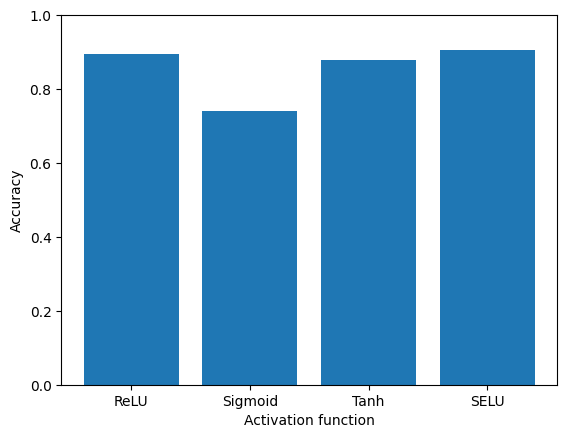

In [14]:
plt.bar(names, accuracies)
plt.ylabel('Accuracy')
plt.ylim(0.0, 1.0)
plt.xlabel('Activation function')
plt.show()